In [1]:
# This code works in Python 3.10.6
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from typing import Dict, List, Union
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.datasets import IMDB
import random
import torch
import dgl
from torch import optim
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
import torch.nn.functional as F
import torch_geometric.utils.convert
from torch_geometric.nn import HANConv
import seaborn as sns
from collections import Counter
import os
import glob
import warnings
warnings.filterwarnings('ignore')

Create Metagraph

In [2]:
dataset = IMDB(root='./imdb_data')
data = dataset[0]
print(data)

HeteroData(
  movie={
    x=[4278, 3066],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278],
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)


In [3]:
#Create metagraph
g = torch_geometric.utils.convert.to_dgl(data)
meta_g= g.metagraph()

In [4]:
dataset = dataset = IMDB(root='./imdb_data')
data = dataset[0]
data

HeteroData(
  movie={
    x=[4278, 3066],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278],
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)

Train IMDB

In [5]:
#https://github.com/pyg-team/pytorch_geometric/blob/master/examples/hetero/han_imdb.py

class HAN(nn.Module):
    def __init__(self, in_channels: Union[int, Dict[str, int]],
                 out_channels: int, hidden_channels=128, heads=8):
        super().__init__()
        self.han_conv = HANConv(in_channels, hidden_channels, heads=heads,
                                dropout=0.6, metadata=data.metadata())
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        out = self.han_conv(x_dict, edge_index_dict)
        out = self.lin(out['movie'])
        return out


model = HAN(in_channels=-1, out_channels=3)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
data, model = data.to(device), model.to(device)

with torch.no_grad():  # Initialize lazy modules.
    out = model(data.x_dict, data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)


def train() -> float:
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['movie'].train_mask
    loss = F.cross_entropy(out[mask], data['movie'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test() -> List[float]:
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)

    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data['movie'][split]
        acc = (pred[mask] == data['movie'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs


best_val_acc = 0
start_patience = patience = 100
for epoch in range(1, 100):

    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch%10==0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
              f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

    if best_val_acc <= val_acc:
        patience = start_patience
        best_val_acc = val_acc
    else:
        patience -= 1

    if patience <= 0:
        print('Stopping training as validation accuracy did not improve '
              f'for {start_patience} epochs')
        break

Epoch: 010, Loss: 0.7072, Train: 0.9100, Val: 0.5550, Test: 0.5196
Epoch: 020, Loss: 0.3248, Train: 0.9875, Val: 0.6175, Test: 0.5768
Epoch: 030, Loss: 0.1968, Train: 0.9950, Val: 0.6250, Test: 0.5690
Epoch: 040, Loss: 0.1601, Train: 0.9975, Val: 0.6300, Test: 0.5679
Epoch: 050, Loss: 0.1347, Train: 1.0000, Val: 0.6250, Test: 0.5699
Epoch: 060, Loss: 0.1336, Train: 1.0000, Val: 0.6275, Test: 0.5710
Epoch: 070, Loss: 0.1176, Train: 0.9975, Val: 0.6125, Test: 0.5739
Epoch: 080, Loss: 0.1065, Train: 1.0000, Val: 0.6200, Test: 0.5730
Epoch: 090, Loss: 0.0939, Train: 1.0000, Val: 0.6150, Test: 0.5745


In [6]:
def remap_indices(node_list):
    val_list = [*range(0, len(node_list), 1)]
    return dict(zip(node_list,val_list))  

In [7]:
def preprocess_edges(edgelist,node_list):
    res = [[node_list[i] for i, j in edgelist],[node_list[j] for i, j in edgelist]] 
    node_from = torch.tensor(res[0])
    node_to = torch.tensor(res[1])
    edges = torch.concat((node_from,node_to)).reshape(-1,len(node_from))
    return edges

In [8]:
def get_node_type(node_type):
    if node_type == 1:
        return 'actor'
    elif node_type == 0:
        return 'director'
    elif node_type == 2:
        return 'movie'


In [9]:
all_edges = {}

In [10]:
#List of edges in metagraph of IMDB
list(meta_g.edges())

[('actor', 'movie'),
 ('movie', 'actor'),
 ('movie', 'director'),
 ('director', 'movie')]

In [11]:
def create_dataset(nodes,edges,movie_df,director_df,actor_df,node_id,df_graph):
    movie = np.asarray(movie_df.drop(columns=['class']))
    director = np.asarray(director_df)
    actor = np.asarray(actor_df)
   
    x_movie = torch.tensor(movie).to(dtype=torch.float32)
    y_movie = torch.tensor(np.array(movie_df["class"]), dtype=torch.long)
    x_director = torch.tensor(director).to(dtype=torch.float32)
    x_actor = torch.tensor(actor).to(dtype=torch.float32)
    
    #Edges
    source,dest =list(map(list, zip(*edges)))

    movie_to_director = []
    director_to_movie = []
    movie_to_actor = []
    actor_to_movie = []
    remaining_edges = []

    class_dict = {'Director':0, 'Actor':1, 'Movie':2}

    for i in range(len(edges)):

        if (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Movie']) and \
        (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Director']):
                movie_to_director.append((int(source[i]),int(dest[i])))

        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Director']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Movie']):
                director_to_movie.append((int(source[i]),int(dest[i])))

        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Movie']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Actor']):
                movie_to_actor.append((int(source[i]),int(dest[i])))

        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Actor']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Movie']):
                actor_to_movie.append((int(source[i]),int(dest[i])))

        else:
            #The edges not present in the metagraph  
            source_node_type = get_node_type(df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0])
            dest_node_type = get_node_type(df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0])
            remaining_edges.append((source_node_type,dest_node_type))
            #remaining_edges.append((int(source[i]),int(dest[i])))
            
    all_edges[node_id] = [*movie_to_director,*movie_to_actor,*director_to_movie,*actor_to_movie]
            
    movie = list(df_graph[df_graph['class'] == 2]['nodeId'])
    movie = [int(i) for i in movie]
    movie_nodes_mapping = remap_indices(movie)
    director = list(df_graph[df_graph['class'] == 0]['nodeId'])
    director = [int(i) for i in director]
    director_nodes_mapping = remap_indices(director)
    actor = list(df_graph[df_graph['class'] == 1]['nodeId'])
    actor = [int(i) for i in actor]
    actor_nodes_mapping = remap_indices(actor)


    node_list = {}
    for d in [movie_nodes_mapping, director_nodes_mapping, actor_nodes_mapping]:
        node_list.update(d)         

    #Create Hetero Data      
    small_graph = HeteroData({'movie':{'x': x_movie, 'y':y_movie}, 
                              'director':{'x': x_director},'actor':{'x': x_actor}})

    if movie_to_director:
        edge_index_movie_director = preprocess_edges(movie_to_director,node_list)
        small_graph['movie','to','director'].edge_index = edge_index_movie_director
        
    if director_to_movie:
        edge_index_director_movie = preprocess_edges(director_to_movie,node_list)
        small_graph['director','to','movie'].edge_index = edge_index_director_movie
    
    if actor_to_movie:
        edge_index_actor_movie = preprocess_edges(actor_to_movie,node_list)
        small_graph['actor','to','movie'].edge_index = edge_index_actor_movie
        
    if movie_to_actor:
        edge_index_movie_actor = preprocess_edges(movie_to_actor,node_list)
        small_graph['movie','to','actor'].edge_index = edge_index_movie_actor

    #Removing isolated nodes
    transform = T.Compose([T.remove_isolated_nodes.RemoveIsolatedNodes()])
    small_graph = transform(small_graph)
    #Adding test mask for prediction
    transform = T.RandomNodeSplit(split='train_rest', num_val=0.0, num_test=1.0)
    small_graph = transform(small_graph)
            
    return small_graph, remaining_edges

In [12]:
def evaluate_gnn(small_graph):
    with torch.no_grad():
        model.eval()
        #The pred is not used for accuracy, the softmax is used
        pred = model(small_graph.x_dict, small_graph.edge_index_dict).argmax(dim=-1)
        
        #Getting class prediction probabilities from the softmax layer
        softmax = model(small_graph.x_dict, small_graph.edge_index_dict).softmax(dim=-1)
        
        mask = small_graph['movie'].test_mask
        correct = (pred[mask] == small_graph['movie'].y[mask])
               
        print(small_graph)
        print('Prediction:',pred[mask])
        print('Ground Truth:',small_graph['movie'].y[mask])
        print(correct)
        print(softmax)
        
        correct_indices = [i for i, x in enumerate(correct.tolist()) if x]
        print('correct indices',correct_indices)
        
        #Taking softmax values of the nodes for which prediction is correct
        softmax_pred_list = [softmax.tolist()[i] for i in correct_indices]
        #print(softmax_pred_list)
        print('------------------------------------------------------------------')
        
        return softmax_pred_list, correct_indices

In [13]:
def apply_threshold(df):
    return df.applymap(lambda x: 0.0 if x<0.0 else 1.0)

In [14]:
def get_real_graph(size):
    real_graph = nx.Graph()
    if(size <= 5):
        real_graph = nx.read_gexf(real_graph_path+'real_G5.gexf')
    elif(size <= 10):
        real_graph = nx.read_gexf(real_graph_path+'real_G10.gexf')
    elif(size <= 15):
        real_graph = nx.read_gexf(real_graph_path+'real_G15.gexf')

    return real_graph

In [15]:
print('Original no of graphs:',len([name for name in glob.glob('../syn_vae/imdb/*')]))

Original no of graphs: 242


In [16]:
softmax_dict = {}
nodefeature_dict = {}
graph_dict = {}
original_edge_count = []
removed_edge_count = []
removed_edges_list = []
rootdir = '../syn_vae/imdb/'

real_graph_path = '../real_graphs/imdb/'
dir_list = []
for subdir, dirs,files in os.walk(rootdir):
    
    if files:
        graph_path = os.path.join(subdir, files[0])
        class_path = os.path.join(subdir, files[1])       
        feature_path = os.path.join(subdir, files[2])
        
        graph = nx.read_gexf(graph_path)
        filename = os.path.basename(graph_path)
        graph_id= filename.split('.')[0]
        #print(graph_id)
        
        nodeId_list = []
        
        for key, value in graph.nodes(data=True):
            nodeId_list.append(key)
            edges = [e for e in graph.edges]
            
        node_type_list = torch.load(class_path).detach().numpy()
        
        df_graph = pd.DataFrame()
        df_graph["nodeId"] = nodeId_list
        df_graph["class"] = node_type_list
        
        
        df_feature = pd.DataFrame(torch.load(feature_path).detach().numpy())        
        df_feature["class"] = node_type_list
        
        real_graph = get_real_graph(len(nodeId_list))
        
        node_label_list = []
        for n in real_graph.nodes:
            node_type = real_graph.nodes[n]["node_type"] 
            if node_type == 2:
                node_class = real_graph.nodes[n]["class"]
                node_label_list.append(node_class)
                
        
        movie_node_features = apply_threshold(df_feature[df_feature['class'] == 2].drop(['class'], axis = 1))

        
        if node_label_list:
            labels = []
            unique_labels = list(set(node_label_list))

            for i in range(0,len(movie_node_features)):
                labels.append(random.choice(unique_labels))
            
            movie_node_features['class']= labels

            director_node_features = df_feature[df_feature['class'] == 0].drop(['class'], axis = 1)
            actor_node_features = df_feature[df_feature['class'] == 1].drop(['class'], axis = 1)


            small_graph_data, removed_edges = create_dataset(nodeId_list,edges,
                                  movie_node_features,director_node_features,
                                  actor_node_features,graph_id,df_graph)
    
            edge_list = all_edges[graph_id]
            graph = nx.Graph(edge_list)
            if not nx.is_empty(graph) and nx.is_connected(graph):
            
                
                if (small_graph_data['movie'].x.nelement()!=0) and \
                (small_graph_data['actor','to','movie']) :
                    print(graph_path)
                    print('node count',small_graph_data.num_nodes)
                    print('edge count',small_graph_data.num_edges)
                
                    original_edge_count.append(len(edges))
                    removed_edge_count.append(len(removed_edges))
                    removed_edges_list.append(set(removed_edges))
                    print('Original edge_count',len(edges))
                    print('Removed edge_count',len(removed_edges))
                    print('Removed edges',removed_edges)
                    softmax, correct_indices = evaluate_gnn(small_graph_data)
                    softmax_dict[graph_id] = softmax
                    nodefeature_dict[graph_id]={'movie':small_graph_data['movie'].x[correct_indices],
                                         'director':small_graph_data['director'].x,
                                         'actor':small_graph_data['actor'].x}
                    graph_dict[graph_id]=df_graph

        
        

../syn_vae/imdb/sync101415233229/sync101415233229_G5.gexf
node count 3
edge count 2
Original edge_count 4
Removed edge_count 2
Removed edges [('actor', 'actor'), ('actor', 'actor')]
HeteroData(
  movie={
    x=[2, 3066],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2],
  },
  director={ x=[0, 3066] },
  actor={ x=[1, 3066] },
  (actor, to, movie)={ edge_index=[2, 1] },
  (movie, to, actor)={ edge_index=[2, 1] }
)
Prediction: tensor([2, 1])
Ground Truth: tensor([2, 2])
tensor([ True, False])
tensor([[3.2554e-01, 3.3253e-01, 3.4193e-01],
        [6.8122e-04, 9.9896e-01, 3.5600e-04]])
correct indices [0]
------------------------------------------------------------------
../syn_vae/imdb/sync105908233241/sync105908233241_G5.gexf
node count 3
edge count 2
Original edge_count 5
Removed edge_count 3
Removed edges [('actor', 'actor'), ('actor', 'actor'), ('actor', 'actor')]
HeteroData(
  movie={
    x=[2, 3066],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[

../syn_vae/imdb/sync655675233353/sync655675233353_G15.gexf
HeteroData(
  movie={
    x=[2, 3066],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  director={ x=[2, 3066] },
  actor={ x=[11, 3066] },
  (actor, to, movie)={ edge_index=[2, 3] }
)
Prediction: tensor([2, 2])
Ground Truth: tensor([2, 2])
tensor([True, True])
tensor([[0.1545, 0.1130, 0.7325],
        [0.0071, 0.0089, 0.9839]])
correct indices [0, 1]
------------------------------------------------------------------
../syn_vae/imdb/sync396923233234/sync396923233234_G4.gexf
HeteroData(
  movie={
    x=[2, 3066],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  director={ x=[1, 3066] },
  actor={ x=[1, 3066] },
  (director, to, movie)={ edge_index=[2, 1] },
  (actor, to, movie)={ edge_index=[2, 1] },
  (movie, to, actor)={ edge_index=[2, 1] }
)
Prediction: tensor([2, 1])
Ground Truth: tensor([2, 2])
tensor([ True, False])
tensor([[0.3317, 0.3257, 0.3426],
        [0.0726, 0.4793,

../syn_vae/imdb/sync800582233228/sync800582233228_G5.gexf
HeteroData(
  movie={
    x=[2, 3066],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  director={ x=[1, 3066] },
  actor={ x=[2, 3066] },
  (actor, to, movie)={ edge_index=[2, 1] },
  (movie, to, actor)={ edge_index=[2, 1] }
)
Prediction: tensor([2, 1])
Ground Truth: tensor([2, 2])
tensor([ True, False])
tensor([[3.3169e-01, 3.2573e-01, 3.4257e-01],
        [6.3643e-04, 9.9333e-01, 6.0293e-03]])
correct indices [0]
------------------------------------------------------------------
../syn_vae/imdb/sync803036233441/sync803036233441_G13.gexf
HeteroData(
  movie={
    x=[2, 3066],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  director={ x=[3, 3066] },
  actor={ x=[8, 3066] },
  (movie, to, director)={ edge_index=[2, 1] },
  (director, to, movie)={ edge_index=[2, 2] },
  (actor, to, movie)={ edge_index=[2, 2] },
  (movie, to, actor)={ edge_index=[2, 1] }
)
Prediction: tensor([1, 0

In [17]:
print("No. of graphs evaluated: ",len(softmax_dict))

No. of graphs evaluated:  89


In [18]:
print('Average number of original edges',round(np.mean(original_edge_count)))

Average number of original edges 10


In [19]:
print('Average number of edges removed',round(np.mean(removed_edge_count)))

Average number of edges removed 5


In [20]:
#The edges that are removed across all graphs
print('Edges removed', set.union(*removed_edges_list))

Edges removed {('actor', 'director'), ('director', 'actor'), ('actor', 'actor'), ('director', 'director'), ('movie', 'movie')}


In [21]:
#Getting the list of predictions for each class
prob_class0_dict = {}
prob_class1_dict = {}
prob_class2_dict = {}

for nodeid in softmax_dict:
    list0= []
    list1= []
    list2= []

    if len(softmax_dict[nodeid]) > 0:
        list0= []
        list1= []
        list2= []


        for prob in softmax_dict[nodeid]:        
            list0.append(prob[0])        
            list1.append(prob[1]) 
            list2.append(prob[2]) 


     #Taking max probability of all nodes of each class in a graph
    if len(list0) != 0:
        prob_class0_dict[nodeid]=max(list0)
    if len(list1) != 0:
        prob_class1_dict[nodeid]=max(list1)
    if len(list2) != 0:
        prob_class2_dict[nodeid]=max(list2)

In [22]:
max_pred0 = max(prob_class0_dict.values())
max_pred1 = max(prob_class1_dict.values())
max_pred2 = max(prob_class2_dict.values())

In [23]:
class0_graphid = max(prob_class0_dict, key=prob_class0_dict.get)
class1_graphid = max(prob_class1_dict, key=prob_class1_dict.get)
class2_graphid = max(prob_class2_dict, key=prob_class2_dict.get)

In [24]:
print(class0_graphid)
print(class1_graphid)
print(class2_graphid)

sync66614233322_G10
sync20423233414_G15
sync912805233352_G13


In [25]:
def plot_graph(graphid, max_pred,nodetype,edges,graph):

    classes = []
    G = nx.Graph(edges)
    df_graph = graph_dict[graphid]
    for g in G.nodes():
        #print(g)
        #print(df_graph.loc[g]['class'])
        if df_graph.loc[df_graph['nodeId'] == str(g), 'class'].values[0] == 0:
            classes.append(0)
        if df_graph.loc[df_graph['nodeId'] == str(g), 'class'].values[0] == 1:
            classes.append(1)
        if df_graph.loc[df_graph['nodeId'] == str(g), 'class'].values[0]== 2:
            classes.append(2)
   
    
    color_class_map = {0: 'blue', 1: 'red', 2: 'darkgreen'}
    
    nx.set_node_attributes(G, dict(zip(G.nodes(), classes)), 'class')
    
    print('Number of nodes: ',G.number_of_nodes())
    print('graph id: ',graphid)
    print(f'Max pred probability for class {nodetype} is {max_pred}')

    nx.draw(G, 
    with_labels=False, node_color=[color_class_map[node[1]['class']] 
                        for node in G.nodes(data=True)], 
            node_size=100,
        font_color='black')
    plt.show()

In [26]:
def index_2d(prob_list, v):
    for i, x in enumerate(prob_list):
        if v in x:
            return (i, x.index(v))

In [27]:
plt.rcParams.update({'axes.ymargin': 0.2})

In [28]:
def count_plot(feat_list):
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.countplot(x=0,ax=ax,data=pd.DataFrame(feat_list),width=0.3)
    for i in ax.containers:
        ax.bar_label(i,fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('feature values',fontsize=20)
    plt.ylabel('feature count',fontsize=20)

    plt.show()

Number of nodes:  7
graph id:  sync66614233322_G10
Max pred probability for class 0 is 0.9045699238777161


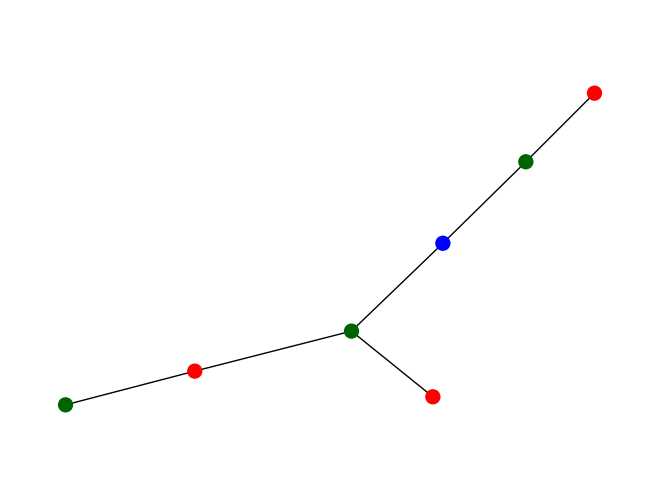

In [55]:
explanation_graph0 = plot_graph(class0_graphid, max_pred0, 0, all_edges[class0_graphid],graph_dict[class0_graphid])

In [30]:
ind= index_2d(softmax_dict[class0_graphid], max_pred0)[0]
list0= nodefeature_dict[class0_graphid]['movie'].numpy()[ind]
Counter(list0)

Counter({1.0: 1568, 0.0: 1498})

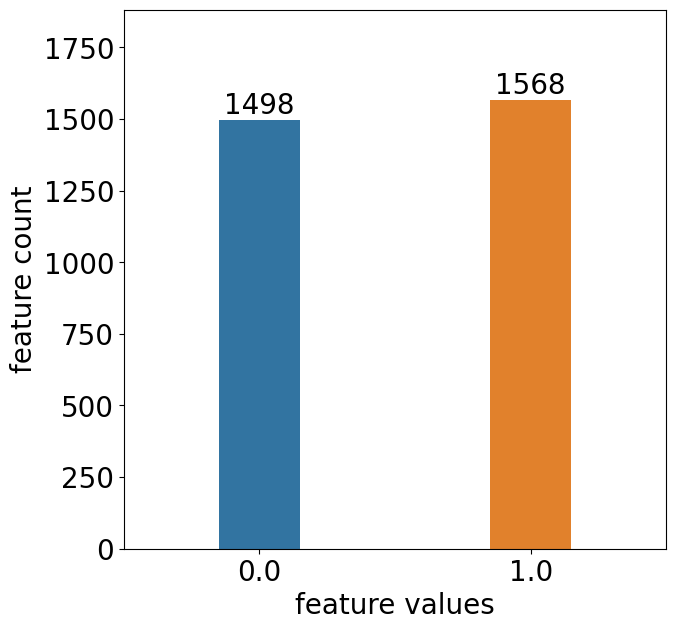

In [31]:
count_plot(list0)

Number of nodes:  13
graph id:  sync20423233414_G15
Max pred probability for class 1 is 0.48421138525009155


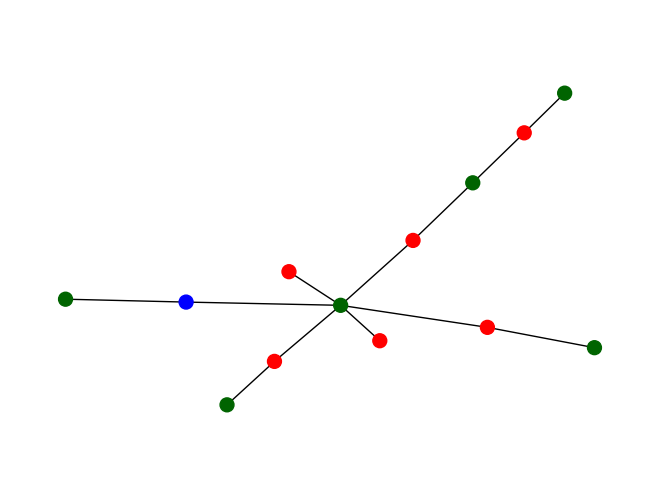

In [53]:
explanation_graph1 = plot_graph(class1_graphid, max_pred1, 1, all_edges[class1_graphid],graph_dict[class1_graphid])

In [33]:
ind= index_2d(softmax_dict[class1_graphid], max_pred1)[0]
list1= nodefeature_dict[class1_graphid]['movie'].numpy()[ind]
Counter(list1)

Counter({0.0: 1554, 1.0: 1512})

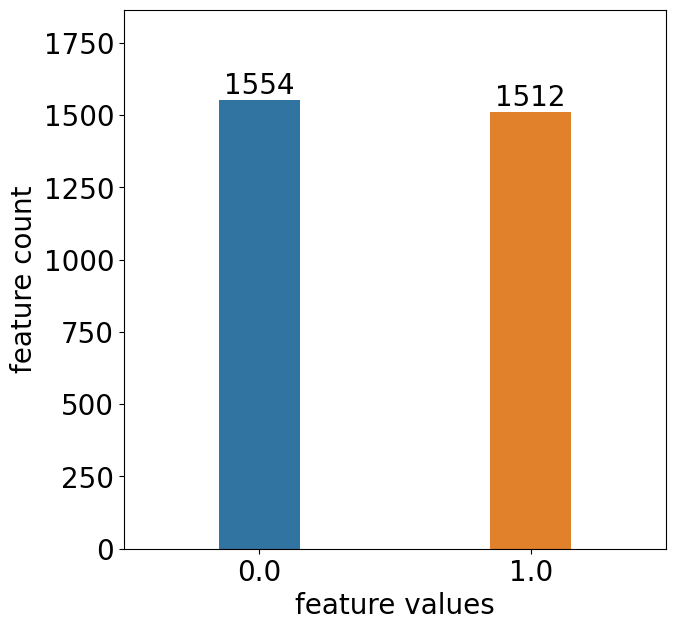

In [34]:
count_plot(list1)

Number of nodes:  5
graph id:  sync912805233352_G13
Max pred probability for class 2 is 0.9693044424057007


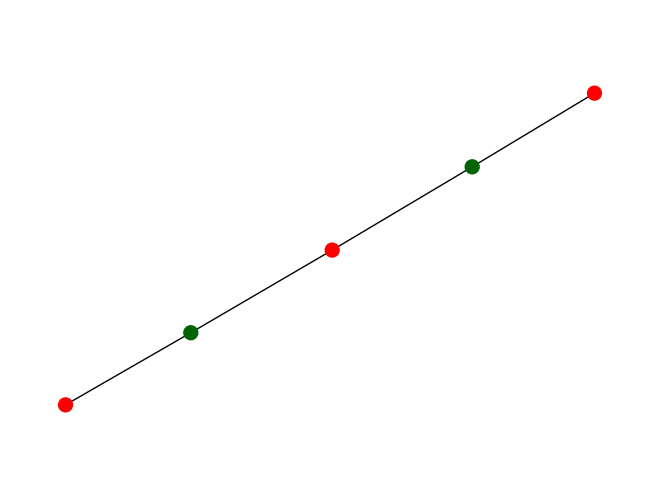

In [35]:
explanation_graph2 = plot_graph(class2_graphid, max_pred2, 2, all_edges[class2_graphid],graph_dict[class2_graphid])

In [36]:
ind= index_2d(softmax_dict[class2_graphid], max_pred2)[0]
list2= nodefeature_dict[class2_graphid]['movie'].numpy()[ind]
Counter(list2)

Counter({0.0: 1552, 1.0: 1514})

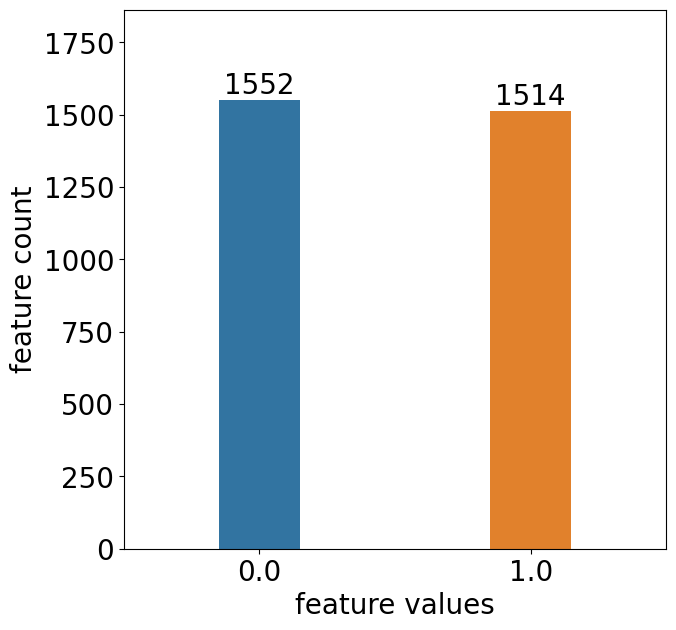

In [37]:
count_plot(list2)

In [38]:
def print_stat_cont_features(df):
    #print('summary',df.describe())
    print('mean',df.stack().mean())
    print('std dev',df.stack().std())

In [39]:
def plot_node_feat(imp_feat):
    sns.distplot(imp_feat,color= 'orange',hist= False)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Feature values',fontsize=20)
    plt.ylabel('Density',fontsize=20)

    plt.show() 

In [40]:
#Actor
actor0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['actor'].numpy())
print_stat_cont_features(actor0_df)

mean -0.0034187832
std dev 0.11084759


Text(0, 0.5, 'Density')

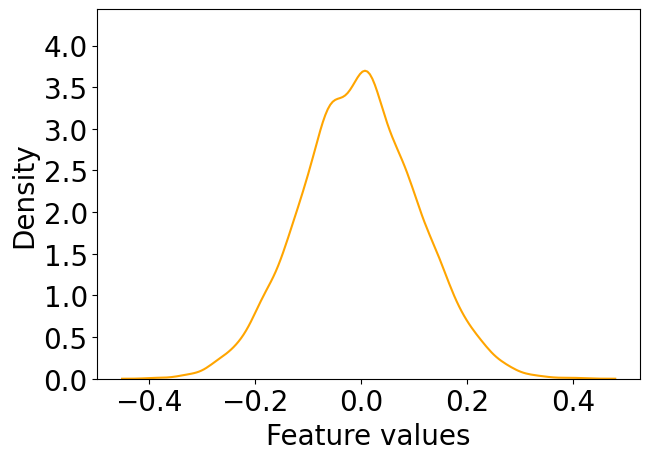

In [61]:
#plot_node_feat(actor0_df)
fig, ax = plt.subplots(figsize=(7,4.8))
#ax.set_aspect('equal', 'datalim')
sns.distplot(actor0_df,color= 'orange',hist= False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Feature values',fontsize=20)
plt.ylabel('Density',fontsize=20)

In [42]:
actor1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['actor'].numpy())
print_stat_cont_features(actor1_df)

mean -0.0005139591
std dev 0.09078958


Text(0, 0.5, 'Density')

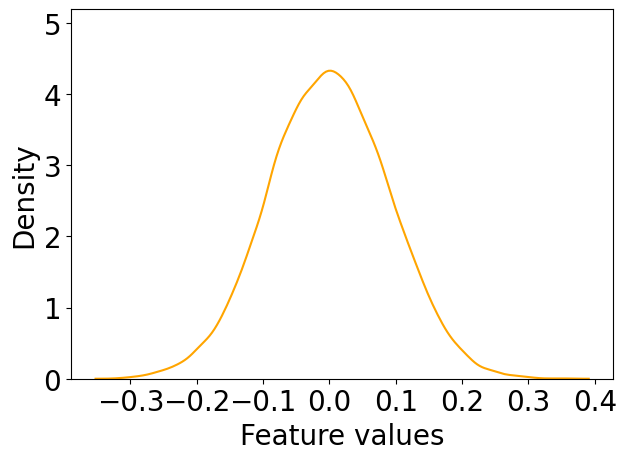

In [59]:
#plot_node_feat(actor1_df)
fig, ax = plt.subplots(figsize=(7,4.8))
#ax.set_aspect('equal', 'datalim')
sns.distplot(actor1_df,color= 'orange',hist= False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Feature values',fontsize=20)
plt.ylabel('Density',fontsize=20)

In [44]:
actor2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['actor'].numpy())
print_stat_cont_features(actor2_df)

mean -0.00035199613
std dev 0.0971085


Text(0, 0.5, 'Density')

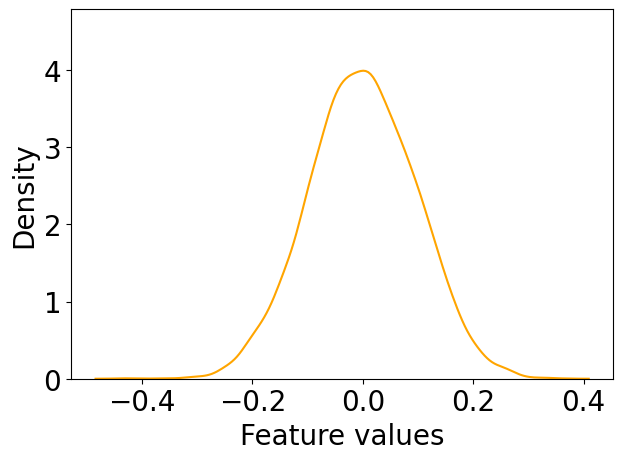

In [60]:
#plot_node_feat(actor2_df)
fig, ax = plt.subplots(figsize=(7,4.8))
#ax.set_aspect('equal', 'datalim')
sns.distplot(actor2_df,color= 'orange',hist= False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Feature values',fontsize=20)
plt.ylabel('Density',fontsize=20)

In [46]:
#Director
director0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['director'].numpy())
print_stat_cont_features(director0_df)

mean -0.0028763039
std dev 0.10981101


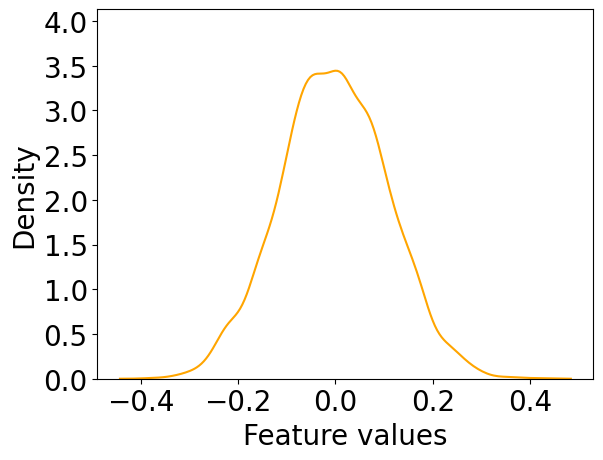

In [47]:
plot_node_feat(director0_df)

In [50]:
director1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['director'].numpy())
print_stat_cont_features(director1_df)

mean 0.0029148334
std dev 0.08941308


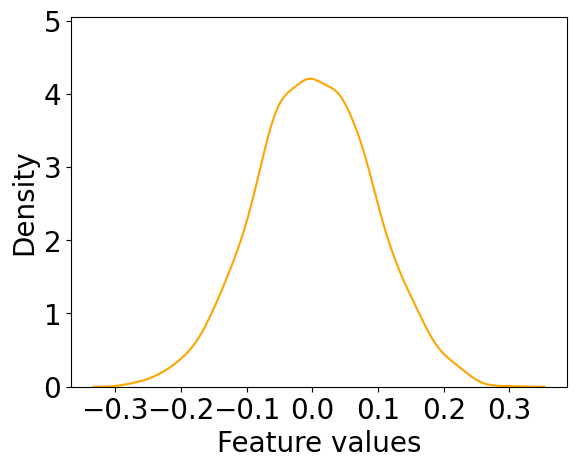

In [52]:
plot_node_feat(director1_df)